In [1]:
%load_ext autoreload
%autoreload 2
%run A_simple_net.ipynb

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.2
matplotlib: 3.3.2
pyNN      : 0.9.5
neo       : 0.8.0
nixio     : 1.5.0b6
pandas    : 0.25.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: inv-ope-de06

Git hash: de3343c7daff65f2ff54837d1755f0a1ea4c2422

Git repo: https://github.com/SpikeAI/2020-11_brainhack_Project7

Git branch: main



In [4]:
%mkdir -p outputs

In [4]:
%mkdir -p Results/20201204/

# scanning over single parameters

## initializing parameters

In [2]:
tag = '2020-12-04_scan_' + simulator

In [3]:
buildCPUTime, simCPUTime, writeCPUTime = run(verbose=True)

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.
2020-12-04 13:20:45,028 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:20:45,031 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
0 Setting up recording...0%                                                                                                                                                                                                                                                                                                                                                               
0 Running simulation...
0 Writing data to file...

--- Vogels-Abbott Network Simulation ---
Nodes                  : 1
Number of Neurons      : 1000
Excitatory conductance : 4 nS
Inhibitory conductance : 51 nS
Excitatory rate        : 0.715 Hz
Inhibitory rate        : 0.73 Hz
Build time             : 2651.85 ms
Simulation time        : 2434.57 ms
Writing time           : 196.3 ms


## Running Model and Loading Results

In [5]:
import os
import pandas as pd
verbose = True
def scan(variable, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}_{variable}.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=[variable, 'buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, value in enumerate(values):
            if verbose: print(f'{variable=}---{value=}')
            args = {}
            args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= {variable: value, 'buildCPUTime':buildCPUTime, 'simCPUTime':simCPUTime, 'writeCPUTime':writeCPUTime}
        df.to_json(filename)
    return df

In [6]:
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression
def plot(df, do_intercept=False):
    variable = df.columns[0]
    fig, ax = plt.subplots(figsize=(8,8))
    
    for regressor, color in zip(['buildCPUTime', 'simCPUTime', 'writeCPUTime'],
                                ['r', 'g', 'b']):

        import patsy
        if do_intercept:
            y, X = patsy.dmatrices(f'{regressor} ~ {variable}', data=df, return_type='dataframe')
        else:
            y, X = patsy.dmatrices(f'{regressor} ~ 0 + {variable}', data=df, return_type='dataframe')

        import statsmodels.api as sm
        fit = sm.OLS(y, X).fit()
        print(fit.summary())

        if do_intercept: intercept = fit.params.Intercept
        slope = fit.params[variable]

        values = np.array(df[variable])
        if do_intercept:
            ax.plot(values, intercept + slope*values, c=color, lw=2, label=f"{regressor}={slope:.3f}*{variable} + {intercept:.3f}")
        else:
            ax.plot(values, slope*values, c=color, lw=2, label=f"{regressor}={slope:.3f}*{variable}")
        df.plot(x=variable, y=regressor, c=color, lw=1, ls='-.', ax=ax, legend=False)

    ax.set_xlim(0)
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(0)
    ax.legend()
    return fig, ax

## plot as a function of neuron numbers

In [7]:
import numpy as np
N_pops = np.array([int(k)**2 for k in np.linspace(8**2, 45**2, 14, endpoint=True)**.5])
N_pops

array([  64,  196,  361,  484,  625,  784,  961, 1089, 1225, 1369, 1521,
       1681, 1849, 2025])

In [8]:
results_pop = scan('N_pop', N_pops)

Loaded file


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14


                                 OLS Regression Results                                
Dep. Variable:           buildCPUTime   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              5666.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):                    1.50e-18
Time:                        13:20:50   Log-Likelihood:                         -66.297
No. Observations:                  14   AIC:                                      134.6
Df Residuals:                      13   BIC:                                      135.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

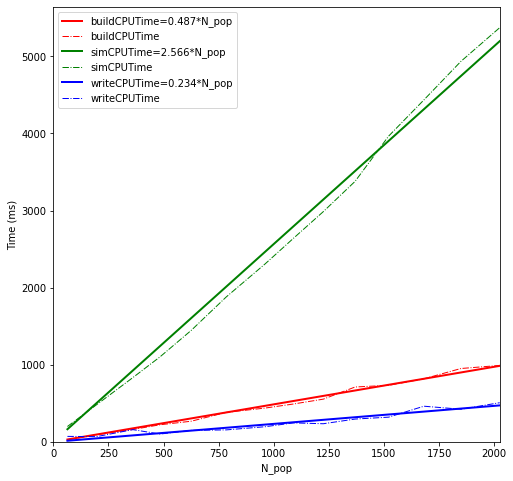

In [9]:
fig, ax = plot(results_pop)

In [10]:
fig.savefig(tag + '_N_pop.png')

## plot as a function of simtime

In [11]:
simtimes = np.linspace(500, 3000, 15, endpoint=True)
simtimes

array([ 500.        ,  678.57142857,  857.14285714, 1035.71428571,
       1214.28571429, 1392.85714286, 1571.42857143, 1750.        ,
       1928.57142857, 2107.14285714, 2285.71428571, 2464.28571429,
       2642.85714286, 2821.42857143, 3000.        ])

In [12]:
results_simtime = scan('simtime', simtimes)

Loaded file


                            OLS Regression Results                            
Dep. Variable:           buildCPUTime   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.140
Date:                Fri, 04 Dec 2020   Prob (F-statistic):              0.305
Time:                        13:20:51   Log-Likelihood:                -62.102
No. Observations:                  15   AIC:                             128.2
Df Residuals:                      13   BIC:                             129.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    493.2684     10.450     47.204      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15


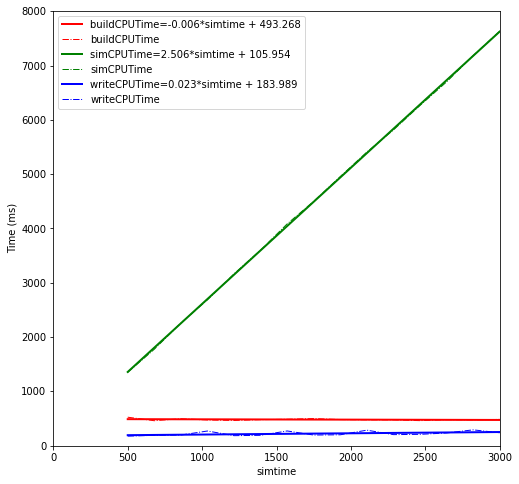

In [13]:
fig, ax = plot(results_simtime, do_intercept=True)      

In [14]:
fig.savefig(tag + '_simtime.png')

# scanning over two parameters

## Setting-up model and initializing parameters

In [15]:
tag = '2020-12-04_scan-2D_' + simulator

## Running Model and Loading Results

In [16]:
variables = ['N_pop', 'simtime']
filename = f'outputs/{tag}'
for variable in variables: filename +=  '_' + variable
filename += '.json'

In [37]:
import os
import time
import pandas as pd
verbose = True
def scan(variables, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}'
    for variable in variables: filename +=  '_' + variable
    filename += '.json'
    try:
        caca
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, values_ in enumerate(values):
            if verbose: print(f'{variable=}---{values_=}')
            args = {}
            for variable, value in zip(variables, values_):
                args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= dict(zip(variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'], 
                                list(values_) + [buildCPUTime, simCPUTime, writeCPUTime]))

        df.to_json(filename)
        
    return df

## Running time as a function of neuron numbers and simtime

In [38]:
import numpy as np

In [39]:
N_trials = 200
N_pops = [int(k)**2 for k in np.linspace(15, 60, N_trials, endpoint=True)]
simtimes = np.linspace(200, 3000, N_trials, endpoint=True)

In [40]:
np.random.seed(42)
np.random.shuffle(N_pops)
np.random.shuffle(simtimes)
values = zip(N_pops, simtimes)

In [41]:
variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime']

['N_pop', 'simtime', 'buildCPUTime', 'simCPUTime', 'writeCPUTime']

In [42]:
list(values_) + [buildCPUTime, simCPUTime, writeCPUTime]

[1444,
 2254.2713567839196,
 2651.8537998199463,
 2434.570789337158,
 196.30026817321777]

In [43]:
dict(zip(variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'], 
                                list(values_) + [buildCPUTime, simCPUTime, writeCPUTime]))

{'N_pop': 1444,
 'simtime': 2254.2713567839196,
 'buildCPUTime': 2651.8537998199463,
 'simCPUTime': 2434.570789337158,
 'writeCPUTime': 196.30026817321777}

In [44]:
results = scan(variables=variables, values=values)
results

2020-12-04 13:21:48,692 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:21:48,695 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 2676.381909547739)


2020-12-04 13:21:58,166 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:21:58,168 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 664.321608040201)


2020-12-04 13:21:58,937 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:21:58,938 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(441, 1902.5125628140704)


2020-12-04 13:22:01,213 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:01,217 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 2732.663316582915)


/home/laurent/.local/lib/python3.8/site-packages/pyNN/recording/__init__.py:264: UserWarning:Recorded at least one spike after t_stop
2020-12-04 13:22:21,111 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:21,115 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1635.175879396985)


2020-12-04 13:22:30,569 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:30,572 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 2099.497487437186)


2020-12-04 13:22:41,342 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:41,345 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 1438.1909547738694)


2020-12-04 13:22:45,398 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:45,403 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2809, 1269.3467336683418)


2020-12-04 13:22:57,130 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:22:57,135 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2916, 1114.572864321608)


2020-12-04 13:23:08,167 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:08,169 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(625, 1944.7236180904524)


2020-12-04 13:23:11,650 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:11,652 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1705.5276381909548)


2020-12-04 13:23:15,969 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:15,974 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3136, 1972.8643216080402)


2020-12-04 13:23:35,141 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:35,146 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 256.2814070351759)


2020-12-04 13:23:39,109 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:39,112 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 2563.8190954773872)


2020-12-04 13:23:47,022 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:23:47,027 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 2465.326633165829)


2020-12-04 13:24:11,303 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:11,309 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 1184.924623115578)


2020-12-04 13:24:23,779 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:23,781 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 1353.7688442211056)


2020-12-04 13:24:26,850 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:26,854 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2401, 1325.6281407035176)


2020-12-04 13:24:37,332 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:37,335 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 326.63316582914575)


2020-12-04 13:24:39,043 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:39,045 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 1663.316582914573)


2020-12-04 13:24:43,610 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:43,613 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 2057.286432160804)


2020-12-04 13:24:55,610 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:55,613 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 819.0954773869347)


2020-12-04 13:24:56,532 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:24:56,536 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 1410.0502512562814)


2020-12-04 13:25:07,235 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:07,239 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 2887.4371859296484)


2020-12-04 13:25:18,062 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:18,064 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1480.4020100502512)


2020-12-04 13:25:21,901 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:21,903 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(784, 622.1105527638191)


2020-12-04 13:25:23,751 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:23,754 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 1058.2914572864322)


2020-12-04 13:25:27,610 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:27,612 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 973.8693467336684)


2020-12-04 13:25:30,499 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:30,503 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1522.6130653266332)


2020-12-04 13:25:39,718 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:39,722 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1936, 396.9849246231156)


2020-12-04 13:25:43,225 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:43,227 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 2197.989949748744)


2020-12-04 13:25:45,015 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:45,017 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 2366.8341708542716)


2020-12-04 13:25:47,323 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:47,326 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 354.7738693467337)


2020-12-04 13:25:48,506 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:48,508 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 2169.849246231156)


2020-12-04 13:25:54,686 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:54,690 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 411.05527638190955)


2020-12-04 13:25:59,092 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:25:59,095 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 1607.035175879397)


2020-12-04 13:26:06,577 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:06,581 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 200.0)


2020-12-04 13:26:09,221 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:09,225 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 1832.1608040201006)


2020-12-04 13:26:20,974 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:20,979 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 692.462311557789)


2020-12-04 13:26:28,228 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:28,231 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 1804.0201005025126)


2020-12-04 13:26:34,003 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:34,006 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 368.84422110552765)


2020-12-04 13:26:35,856 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:35,863 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 1100.502512562814)


2020-12-04 13:26:49,186 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:49,189 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(529, 2704.522613065327)


2020-12-04 13:26:53,124 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:53,126 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(400, 1424.1206030150754)


2020-12-04 13:26:54,799 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:26:54,802 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1764, 959.7989949748744)


2020-12-04 13:27:00,819 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:00,825 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 987.9396984924623)


2020-12-04 13:27:13,303 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:13,305 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(441, 593.9698492462312)


2020-12-04 13:27:14,288 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:14,290 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 2521.608040201005)


2020-12-04 13:27:16,760 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:16,763 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2209, 1466.3316582914574)


2020-12-04 13:27:27,498 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:27,501 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1156, 790.9547738693468)


2020-12-04 13:27:30,874 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:30,878 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1600, 2240.2010050251256)


2020-12-04 13:27:41,809 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:41,814 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2916, 1213.065326633166)


2020-12-04 13:27:53,934 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:53,936 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(256, 748.7437185929648)


2020-12-04 13:27:54,627 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:27:54,630 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1381.9095477386936)


2020-12-04 13:28:03,442 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:28:03,445 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 551.7587939698492)


2020-12-04 13:28:07,365 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:28:07,368 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 1719.5979899497488)


2020-12-04 13:28:12,691 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:28:12,695 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2116, 2915.5778894472364)


2020-12-04 13:28:31,638 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:28:31,642 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1369, 2071.356783919598)


2020-12-04 13:28:40,297 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:28:40,302 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2809, 2549.7487437185932)


2020-12-04 13:29:02,885 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:02,889 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 509.54773869346735)


2020-12-04 13:29:05,685 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:05,690 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2809, 1691.4572864321608)


2020-12-04 13:29:21,455 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:21,459 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 847.2361809045226)


2020-12-04 13:29:25,483 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:25,485 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(484, 1227.1356783919598)


2020-12-04 13:29:27,315 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:27,317 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 889.4472361809045)


2020-12-04 13:29:28,196 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:28,198 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(484, 1297.4874371859296)


2020-12-04 13:29:30,106 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:30,109 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 1283.4170854271358)


2020-12-04 13:29:37,754 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:37,757 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(576, 1198.994974874372)


2020-12-04 13:29:39,928 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:39,934 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 1002.0100502512563)


2020-12-04 13:29:51,645 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:51,648 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1225, 2113.56783919598)


2020-12-04 13:29:59,738 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:29:59,742 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 537.6884422110553)


2020-12-04 13:30:04,386 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:04,389 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(676, 439.1959798994975)


2020-12-04 13:30:05,684 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:05,687 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1789.9497487437186)


2020-12-04 13:30:16,734 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:16,738 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2601, 2085.427135678392)


2020-12-04 13:30:34,389 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:34,392 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(576, 636.1809045226131)


2020-12-04 13:30:35,862 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:35,866 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 1072.3618090452262)


2020-12-04 13:30:42,397 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:42,401 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1600, 2338.6934673366836)


2020-12-04 13:30:53,987 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:53,990 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(400, 2957.788944723618)


2020-12-04 13:30:57,194 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:30:57,198 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2116, 2971.859296482412)


2020-12-04 13:31:17,282 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:17,285 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1369, 2817.0854271356784)


2020-12-04 13:31:28,839 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:28,842 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1600, 2943.7185929648244)


2020-12-04 13:31:42,985 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:42,987 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(225, 270.35175879396985)


2020-12-04 13:31:43,348 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:43,351 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 833.1658291457287)


2020-12-04 13:31:46,504 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:46,506 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(625, 2577.889447236181)


2020-12-04 13:31:51,206 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:31:51,211 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 805.0251256281407)


2020-12-04 13:32:01,293 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:01,299 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3364, 2127.638190954774)


2020-12-04 13:32:24,557 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:24,560 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1156, 875.3768844221106)


2020-12-04 13:32:28,334 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:28,339 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2601, 1508.5427135678392)


2020-12-04 13:32:41,771 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:41,774 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(529, 2043.2160804020102)


2020-12-04 13:32:44,916 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:44,921 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 242.2110552763819)


2020-12-04 13:32:49,890 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:49,893 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(784, 453.2663316582915)


2020-12-04 13:32:51,429 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:51,431 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 1747.7386934673368)


2020-12-04 13:32:53,245 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:32:53,249 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2116, 2985.929648241206)


2020-12-04 13:33:13,375 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:33:13,379 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1369, 2803.0150753768844)


2020-12-04 13:33:25,102 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:33:25,104 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(484, 1086.43216080402)


2020-12-04 13:33:26,791 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:33:26,793 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 579.8994974874372)


2020-12-04 13:33:27,484 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:33:27,490 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3364, 1677.3869346733668)


2020-12-04 13:33:46,295 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:33:46,300 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 1860.3015075376884)


2020-12-04 13:34:02,076 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:02,078 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(256, 2873.3668341708544)


2020-12-04 13:34:04,119 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:04,120 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(441, 2718.592964824121)


2020-12-04 13:34:07,380 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:07,383 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1764, 565.8291457286432)


2020-12-04 13:34:11,655 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:11,657 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(225, 2591.959798994975)


2020-12-04 13:34:13,324 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:13,326 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(484, 2296.4824120603016)


2020-12-04 13:34:16,438 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:16,442 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2209, 903.5175879396985)


2020-12-04 13:34:24,075 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:24,080 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2209, 1621.105527638191)


2020-12-04 13:34:36,137 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:36,141 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1521, 2831.1557788944724)


2020-12-04 13:34:50,287 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:50,292 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2209, 608.0402010050252)


2020-12-04 13:34:55,903 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:55,906 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 495.4773869346734)


2020-12-04 13:34:56,527 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:34:56,530 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1395.9798994974874)


2020-12-04 13:35:00,333 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:00,337 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1600, 1016.0804020100503)


2020-12-04 13:35:06,083 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:06,088 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 1255.2763819095478)


2020-12-04 13:35:16,416 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:16,421 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 1846.2311557788946)


2020-12-04 13:35:33,177 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:33,179 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(225, 1888.4422110552764)


2020-12-04 13:35:34,500 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:34,505 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 425.1256281407035)


2020-12-04 13:35:41,788 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:41,793 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2401, 1128.643216080402)


2020-12-04 13:35:51,652 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:51,655 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 2394.974874371859)


2020-12-04 13:35:58,350 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:35:58,354 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1764, 298.4924623115578)


2020-12-04 13:36:01,326 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:01,331 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 467.33668341708545)


2020-12-04 13:36:03,082 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:03,084 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(576, 2380.904522613065)


2020-12-04 13:36:07,111 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:07,115 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2601, 481.4070351758794)


2020-12-04 13:36:12,989 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:12,992 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(441, 382.9145728643216)


2020-12-04 13:36:13,765 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:13,767 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(576, 2859.2964824120604)


2020-12-04 13:36:18,448 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:18,452 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1521, 2901.5075376884424)


2020-12-04 13:36:32,541 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:32,546 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 650.251256281407)


2020-12-04 13:36:39,326 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:39,330 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 1592.964824120603)


2020-12-04 13:36:53,152 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:53,155 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(400, 762.8140703517588)


2020-12-04 13:36:54,255 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:54,257 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(400, 1044.2211055276382)


2020-12-04 13:36:55,656 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:36:55,661 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3136, 1311.5577889447236)


2020-12-04 13:37:10,267 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:10,271 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 678.391959798995)


2020-12-04 13:37:16,915 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:16,919 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 2183.9195979899496)


2020-12-04 13:37:24,528 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:24,531 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(529, 2507.537688442211)


2020-12-04 13:37:28,328 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:28,333 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 1733.6683417085428)


2020-12-04 13:37:44,428 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:44,431 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(625, 2535.6783919597992)


2020-12-04 13:37:49,137 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:37:49,141 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 2690.452261306533)


2020-12-04 13:38:00,037 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:00,042 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2401, 2845.2261306532664)


2020-12-04 13:38:21,899 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:21,902 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(576, 2352.7638190954776)


2020-12-04 13:38:25,926 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:25,930 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2116, 1367.8391959798996)


2020-12-04 13:38:36,393 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:36,395 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(225, 2648.241206030151)


2020-12-04 13:38:38,142 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:38,145 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 2324.6231155778896)


2020-12-04 13:38:48,970 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:48,973 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(676, 1241.2060301507538)


2020-12-04 13:38:51,772 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:38:51,776 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 2788.9447236180904)


2020-12-04 13:39:10,186 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:39:10,191 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 1874.3718592964824)


2020-12-04 13:39:29,580 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:39:29,586 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 945.7286432160804)


2020-12-04 13:39:40,645 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:39:40,651 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3136, 2029.1457286432162)


2020-12-04 13:40:02,327 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:02,330 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(676, 2282.4120603015076)


2020-12-04 13:40:06,978 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:06,981 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 2409.045226130653)


2020-12-04 13:40:15,239 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:15,241 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(484, 312.56281407035175)


2020-12-04 13:40:16,026 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:16,027 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(256, 706.532663316583)


2020-12-04 13:40:16,713 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:16,717 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1521, 2155.7788944723616)


2020-12-04 13:40:27,546 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:27,549 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1225, 861.3065326633166)


2020-12-04 13:40:31,559 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:31,562 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 2479.396984924623)


2020-12-04 13:40:39,973 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:39,979 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2916, 214.07035175879398)


2020-12-04 13:40:44,467 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:40:44,473 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 1775.8793969849246)


2020-12-04 13:41:02,799 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:02,803 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1225, 1030.1507537688442)


2020-12-04 13:41:07,580 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:07,582 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(256, 1761.8090452261308)


2020-12-04 13:41:08,958 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:08,960 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 2620.100502512563)


2020-12-04 13:41:11,077 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:11,079 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(784, 2746.733668341709)


2020-12-04 13:41:17,530 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:17,535 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2809, 284.4221105527638)


2020-12-04 13:41:22,316 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:22,321 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1936, 1578.894472361809)


2020-12-04 13:41:33,038 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:33,041 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 776.8844221105528)


2020-12-04 13:41:33,948 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:33,951 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 2423.115577889447)


2020-12-04 13:41:41,154 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:41:41,159 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2916, 2310.5527638190956)


2020-12-04 13:42:04,084 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:04,093 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 340.7035175879397)


2020-12-04 13:42:08,015 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:08,021 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 2001.0050251256282)


2020-12-04 13:42:26,494 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:26,501 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3136, 1649.246231155779)


2020-12-04 13:42:44,893 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:44,896 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1339.6984924623116)


2020-12-04 13:42:48,733 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:48,736 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 734.6733668341709)


2020-12-04 13:42:50,842 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:42:50,845 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1521, 1986.9346733668342)


2020-12-04 13:43:00,998 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:01,000 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(676, 2451.256281407035)


2020-12-04 13:43:06,012 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:06,018 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 917.5879396984925)


2020-12-04 13:43:18,710 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:18,713 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(784, 1536.6834170854272)


2020-12-04 13:43:22,699 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:22,702 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(625, 2662.311557788945)


2020-12-04 13:43:27,614 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:27,617 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1156, 2634.170854271357)


2020-12-04 13:43:37,068 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:37,070 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 1452.2613065326634)


2020-12-04 13:43:38,679 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:38,681 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 3000.0)


2020-12-04 13:43:45,140 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:43:45,145 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2601, 2493.467336683417)


2020-12-04 13:44:06,915 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:44:06,921 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3364, 2268.3417085427136)


2020-12-04 13:44:32,451 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:44:32,456 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1936, 228.14070351758795)


2020-12-04 13:44:35,532 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:44:35,535 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(529, 1494.4723618090452)


2020-12-04 13:44:38,045 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:44:38,050 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 1170.854271356784)


2020-12-04 13:44:49,175 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:44:49,181 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3364, 1930.6532663316584)


2020-12-04 13:45:11,528 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:45:11,530 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(225, 1550.7537688442212)


2020-12-04 13:45:12,649 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:45:12,652 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(676, 2212.0603015075376)


2020-12-04 13:45:17,218 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:45:17,222 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 2141.708542713568)


2020-12-04 13:45:34,109 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:45:34,114 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1936, 1564.8241206030152)


2020-12-04 13:45:45,034 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:45:45,039 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2401, 1818.0904522613066)


2020-12-04 13:46:00,192 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:00,196 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 1156.78391959799)


2020-12-04 13:46:06,496 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:06,500 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1369, 523.6180904522613)


2020-12-04 13:46:09,803 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:09,807 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 720.6030150753769)


2020-12-04 13:46:15,157 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:15,161 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1156, 2226.130653266332)


2020-12-04 13:46:23,545 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:23,548 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 1916.5829145728644)


2020-12-04 13:46:29,466 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:29,471 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1764, 2774.8743718592964)


2020-12-04 13:46:45,754 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:46:45,761 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3600, 2760.8040201005024)


2020-12-04 13:47:18,989 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:47:18,992 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 1142.713567839196)


2020-12-04 13:47:20,371 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:47:20,376 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 2929.6482412060304)


2020-12-04 13:47:51,847 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:47:51,853 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 2437.185929648241)


2020-12-04 13:47:59,295 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:47:59,299 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 2606.030150753769)


2020-12-04 13:48:11,836 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:48:11,839 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 931.6582914572865)


2020-12-04 13:48:12,907 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:48:12,910 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1225, 2015.0753768844222)


2020-12-04 13:48:21,004 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:48:21,009 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 1958.7939698492462)


2020-12-04 13:48:41,469 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 13:48:41,473 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 2254.2713567839196)


,N_pop,simtime,buildCPUTime,simCPUTime,writeCPUTime
0,1296.0,2676.381910,599.036455,8520.785809,326.922178
1,324.0,664.321608,143.315792,512.142181,98.772764
2,441.0,1902.512563,178.263664,1931.942940,130.185366
3,2500.0,2732.663317,1222.176790,17846.006632,796.371222
4,1849.0,1635.175879,866.493940,8081.131458,480.911016
...,...,...,...,...,...
195,1444.0,2606.030151,1030.984640,11107.993126,378.175497
196,324.0,931.658291,201.613426,747.238398,99.138975
197,1225.0,2015.075377,843.507290,6943.225384,258.156776
198,3025.0,1958.793970,2219.290733,17289.569378,917.819977


## analysis

In [45]:
results_ext = results.copy()
results_ext['simtime_N_pop'] = results_ext['simtime'] * results_ext['N_pop']
results_ext

,N_pop,simtime,buildCPUTime,simCPUTime,writeCPUTime,simtime_N_pop
0,1296.0,2676.381910,599.036455,8520.785809,326.922178,3.468591e+06
1,324.0,664.321608,143.315792,512.142181,98.772764,2.152402e+05
2,441.0,1902.512563,178.263664,1931.942940,130.185366,8.390080e+05
3,2500.0,2732.663317,1222.176790,17846.006632,796.371222,6.831658e+06
4,1849.0,1635.175879,866.493940,8081.131458,480.911016,3.023440e+06
...,...,...,...,...,...,...
195,1444.0,2606.030151,1030.984640,11107.993126,378.175497,3.763108e+06
196,324.0,931.658291,201.613426,747.238398,99.138975,3.018573e+05
197,1225.0,2015.075377,843.507290,6943.225384,258.156776,2.468467e+06
198,3025.0,1958.793970,2219.290733,17289.569378,917.819977,5.925352e+06


In [46]:
variables_ext = ['N_pop', 'simtime_N_pop']
X = results_ext[variables_ext].values.reshape(-1, len(variables_ext))


https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

See https://patsy.readthedocs.io/en/latest/quickstart.html

In [48]:
import patsy
import statsmodels.api as sm

for regressor in ['buildCPUTime', 'simCPUTime', 'writeCPUTime']:
    y = results_ext[regressor].values
    #print(variables_ext, X.shape, y.shape)
    y, X = patsy.dmatrices(f'{regressor} ~ 0 + N_pop + simtime_N_pop', data=results_ext, return_type='dataframe')

    fit = sm.OLS(y, X).fit()
    fit.summary()

    print(f'{regressor} (ms) = {fit.params[0]:.3f} * N_pop + {fit.params[1]*1000:.3f}/1000 * simtime (ms) * N_pop')

buildCPUTime (ms) = 0.583 * N_pop + 0.016/1000 * simtime (ms) * N_pop
simCPUTime (ms) = -0.007 * N_pop + 2.841/1000 * simtime (ms) * N_pop
writeCPUTime (ms) = 0.202 * N_pop + 0.035/1000 * simtime (ms) * N_pop
